In [1]:
import os
import pandas as pd
import numpy as np
import json
import sys
import pickle
import seaborn as sns
import types
import numbers
import _pickle as cPickle
import bz2

from matplotlib import pyplot as plt
#from pandas.io.json import json_normalize

import warnings
warnings.filterwarnings("ignore") # uncomment this for package deprecated warnings 

import logging
logger = logging.getLogger(__name__)

# These lines allow me to see logging.info messages in my jupyter cell output
logger.addHandler(logging.StreamHandler(stream=sys.stdout)) 
logger.setLevel(logging.DEBUG)

%matplotlib inline

from matplotlib import rcParams

In [2]:
# plt.rcParams.update({'figure.autolayout': True, "text.usetex": True,"font.family": "serif"})
params = {"text.usetex": True,
          "font.family" : "serif",
          "font.serif" : ["Computer Modern Serif"]}
#plt.rcParams.update(params)
# rcParams['font.family'] = 'serif' # latex default font
# rcParams['font.serif'] = ['Computer Modern']
sns.set_style('darkgrid')

In [3]:
from process_data_1 import subject_data, trial_data, run_single_subject_gd

### Get a list of all subject id's for analysis.  
This assumes data is organized into subfolders within a parent folder.  <br>
For example... <br>
Parent dir: D:\Data\Driving_1\Spring_2023_pilot\\'
which contains subdirs: 'cb', 'controls_agematched', and 'controls_undergrad'

In [4]:
pickled_data_folder = os.path.join(os.getcwd(), 'pickled-data')

subfolder_list = [f.path.split('_')[0] for f in os.scandir(pickled_data_folder) if (f.name[:5] == 'older' or f.name[:5]=='young')]

print('Subjects to process: ', [subfolder.split(r'/')[-1].split('_')[0] for subfolder in subfolder_list])

Subjects to process:  ['olderDriver8', 'youngerDriver7', 'olderDriver3', 'youngerDriver3', 'olderDriver7', 'youngerDriver12', 'youngerDriver8', 'olderDriver9', 'olderDriver2', 'youngerDriver6', 'olderDriver6', 'youngerDriver2', 'youngerDriver9', 'youngerDriver13', 'olderDriver1', 'youngerDriver5', 'youngerDriver14', 'youngerDriver10', 'olderDriver5', 'youngerDriver1', 'youngerDriver4', 'youngerDriver15', 'youngerDriver11', 'olderDriver4']


### Compile the all_results dataframe

In [5]:
# comment these first two lines if you already ran this block but want to add more subjects to the results
all_results = pd.DataFrame()
all_trial_dicts = []

for subnum, subfolder in enumerate(subfolder_list):  
        
    print(f'** {subnum+1} / {len(subfolder_list)} :  {subfolder.split("/")[-1].split("_")[0]}  **')
    a_subject = subject_data(subfolder, 
                             cbPatient=True, 
                             analyze_gaze=False,
                             offset_car_xz=(-.4304, 0), 
                             use_cached_data=True)

    a_subject.calc_divergence_over_segment_for_all_trials(86,100) # straight road at end only
    a_subject.calc_divergence_over_segment_for_all_trials(14,86) # curve only
    a_subject.calc_divergence_over_segment_for_all_trials(30,70) #  middle 40% of trial
    a_subject.calc_divergence_over_segment_for_all_trials(0,14) # straight part at start only
    a_subject.calc_divergence_over_segment_for_all_trials(0,2) # initial position only
    
    std_devs = []
    for trialIndex, trial_results_row in a_subject.results.iterrows(): 
        a_trial = a_subject.get_trial_from_results(trial_results_row)
        std_devs.append(np.std(a_trial.car_data['divergence']))
    # add in standard deviation for effect size calculations
    a_subject.results['mean_std_dev_divergence'] = np.mean(std_devs)
    
    # AVERAGE WITHIN SUBJECTS FIRST
    numeric_columns = a_subject.results.select_dtypes(include=[np.number]).columns
    numeric_columns = pd.Index(numeric_columns.tolist() + ['ppid', 'turn_direction'])
    results = a_subject.results[numeric_columns].groupby(['ppid','turn_radius','contrast','turn_direction']).agg(np.mean)
    
    
    a_subject.results['subject_group'] = subfolder.split(r'/')[-1].split('_')[0][:5]
    a_subject.trial_dict['subject_group'] = subfolder.split(r'/')[-1].split('_')[0][:5]
    a_subject.results['ppid'] = subfolder.split(r'/')[-1].split('_')[0]
    
    all_results = pd.concat((all_results, a_subject.results), axis=0)
    all_trial_dicts.append(a_subject.trial_dict)

** 1 / 24 :  olderDriver8  **
self.pickle_path:  pickled-data/olderDriver8_pickle_dict.pbz2
Calculating divergence for olderDriver8
Calculating divergence for olderDriver8
Calculating divergence for olderDriver8
Calculating divergence for olderDriver8
Calculating divergence for olderDriver8
** 2 / 24 :  youngerDriver7  **
self.pickle_path:  pickled-data/youngerDriver7_pickle_dict.pbz2
Calculating divergence for youngerDriver7
Calculating divergence for youngerDriver7
Calculating divergence for youngerDriver7
Calculating divergence for youngerDriver7
Calculating divergence for youngerDriver7
** 3 / 24 :  olderDriver3  **
self.pickle_path:  pickled-data/olderDriver3_pickle_dict.pbz2
Calculating divergence for olderDriver3
Calculating divergence for olderDriver3
Calculating divergence for olderDriver3
Calculating divergence for olderDriver3
Calculating divergence for olderDriver3
** 4 / 24 :  youngerDriver3  **
self.pickle_path:  pickled-data/youngerDriver3_pickle_dict.pbz2
Calculating di

### Pointplots for divergence from inner lane - flags for hue of optic flow, turn radius, turn direction

In [6]:
def pointplot_divergence_from_inner_lane(all_results, custom_order, y_label = 'mean_div_from_inner_road_edge', flag_optic_flow = False, flag_turn_radius = False, separate_by_turn_dir=False, exclude=[], save_plot=False):
    '''
    data should be in format of "all_results"
    '''
    fig, ax = plt.subplots() # figsize=(12,6) for ppid

    data = all_results.copy(deep=True)
    data.loc[data['subject_group'] == 'older', 'subject_group'] = 'Older Adults' # rename column
    data.loc[data['subject_group'] == 'young', 'subject_group'] = 'Younger Adults'

    # Convert 'Category' column to a categorical data type with custom order
    data['Category'] = pd.Categorical(data['subject_group'], categories=custom_order, ordered=True)

    if flag_optic_flow:
        subgroup_order = [0.0,0.4,0.8]

        if separate_by_turn_dir:
            grouped_data = data.groupby(['ppid','Category','contrast','turn_direction'], observed=True).mean(numeric_only=True)
        else: grouped_data = data.groupby(['ppid','Category','contrast'], observed=True).mean(numeric_only=True)
        grouped_data = grouped_data.reset_index()

        if separate_by_turn_dir:
            sns.pointplot(data=grouped_data[grouped_data['turn_direction']=='right'], x='Category', y=y_label, units='ppid', hue='contrast', hue_order=subgroup_order, 
                          palette='pastel', errorbar='ci', linestyles='none', dodge=True, order=custom_order)
            sns.pointplot(data=grouped_data[grouped_data['turn_direction']=='left'], x='Category', y=y_label, units='ppid', hue='contrast', hue_order=subgroup_order, 
                          palette='bright', errorbar='ci', linestyles='none', dodge=True, order=custom_order)
        else:

            sns.pointplot(data=data, x='Category', y=y_label, hue='contrast', hue_order=subgroup_order, units='ppid',
                          palette='bright', errorbar='ci', linestyles='none', dodge=True, order=custom_order)
            # show individual data points
            sns.stripplot(data=grouped_data, x="Category", y=y_label, hue='contrast', alpha=0.2, legend=False, palette='bright')
            
        handles, labels = plt.gca().get_legend_handles_labels()  # Get handles and labels from the current axis
        mapping_dict = {'0.0':'Low', '0.4':'Medium','0.8':'High'}
        labels = [*map(mapping_dict.get, labels)]
        ax.legend(handles[:3], labels[:3], title='Optic Flow \nDensity', loc='lower left')
        #ax.get_legend().remove()
        
    elif flag_turn_radius and (flag_optic_flow == False):
        subgroup_order = [35.0,55.0,75.0]

        if separate_by_turn_dir:
            grouped_data = data.groupby(['ppid','Category','turn_radius','turn_direction']).mean(numeric_only=True)
        else: grouped_data = data.groupby(['ppid','Category','turn_radius']).mean(numeric_only=True)
        grouped_data = grouped_data.reset_index()

        if separate_by_turn_dir:
            sns.pointplot(data=grouped_data, x='Category', y=y_label, units='ppid',
                  hue=grouped_data[['turn_direction','turn_radius']].apply(lambda row: f"{row.turn_direction}, {row.turn_radius}", axis=1), 
                  hue_order=subgroup_order, palette='plasma', errorbar='ci', linestyles='none', dodge=True, order=custom_order)
        else:
            sns.pointplot(data=grouped_data, x='Category', y=y_label, units='ppid',
                  hue='turn_radius', hue_order=subgroup_order, palette='plasma',
                  errorbar='ci', linestyles='none', dodge=True, order=custom_order)
        # show individual data points
        sns.stripplot(data=grouped_data, x="Category", y=y_label, hue='turn_radius', alpha=0.3, legend=False, palette='plasma')

        handles, labels = plt.gca().get_legend_handles_labels()  # Get handles and labels from the current axis

        ax.legend(title='Turn Radius', loc='best')
        
    else:
        mapping_dict = {'right':'Right', 'left':'Left'}
        data['turn_direction'] = [*map(mapping_dict.get, data['turn_direction'])]
        
        grouped_data = data.groupby(['ppid','Category','turn_direction']).mean(numeric_only=True)
        grouped_data = grouped_data.reset_index()
        
        sns.pointplot(data=grouped_data, x='Category', y=y_label, 
                  hue='turn_direction', hue_order = ['Left', 'Right'],
                  errorbar='ci', linestyles='none', order=custom_order)
        ax.legend(title='Turn Direction',loc='best')
        sns.stripplot(data=grouped_data, x='Category', y=y_label, hue='turn_direction', alpha=0.3, legend=False)

        #plt.ylim(0.7,2.3)
        #plt.ylim(1.1,1.8)
    if y_label == 'mean_div_from_inner_road_edge_30_70_adjusted':
            ax.set_ylabel('Change in Lane Position (m)')
    else: 
        ax.set_ylabel('Mean Distance \nfrom Inner Road Edge (m)')
    
    ax.set_xlabel('')
    participants_per_group = [[key,len(np.unique(group['ppid']))] for key, group in data[~data['ppid'].isin(exclude)].groupby('subject_group', observed=True)]
    participants_per_group = pd.DataFrame(np.array(participants_per_group).T)
    participants_per_group.columns = participants_per_group.iloc[0]
    participants_per_group = participants_per_group[1:]
    labels = [item.get_text() for item in ax.get_xticklabels()]
    total_participants = 0
    for i in range(len(labels)):
        total_participants += int(participants_per_group[labels[i]].values[0])
        labels[i] = labels[i] + '\nn=' + str(participants_per_group[labels[i]].values[0])
    ax.set_xticklabels(labels)
    
    ax.set_ylim(0.8,2.4)
    ax.axhline(2.0, linestyle='--', color='k')
    
    if save_plot:
        if flag_optic_flow:
            filename = 'Paper2-Pointplot-'+y_label+ '-SeparatedByOF-FINAL-n=' + str(total_participants) + '.svg'
        elif flag_turn_radius:
            filename = 'Paper2-Pointplot-'+y_label+ '-SeparatedByTurnRadius-FINAL-n=' + str(total_participants) + '.svg'
        else:
            filename = 'Paper2-Pointplot-'+y_label+'-FINAL-n=' + str(total_participants) + '.svg'
        print('Saved to: ', filename)
        fig.savefig(filename, dpi=300)

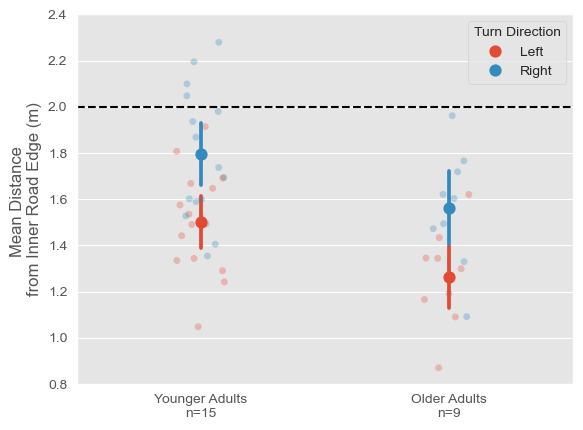

In [7]:
pointplot_divergence_from_inner_lane(all_results, custom_order = ['Younger Adults', 'Older Adults'], y_label='mean_div_from_inner_road_edge_30_70', flag_optic_flow=False, flag_turn_radius=False, save_plot=False)
plt.show()

# The code below is designed to help plot wheel angle by optic flow and turn radius conditions.

In [8]:
#calculating s2s_rmse_wheel_angle

all_rmse = pd.DataFrame()
interp_time_seconds = 7.3 # fix interpolation time for all participants
interp_res_seconds = 1/90
interp_timestamps = np.arange(0, interp_time_seconds, interp_res_seconds) # need to interpolate across time for wheelAngle

for subnum, subfolder in enumerate(subfolder_list):  

    print(f'** {subnum+1} / {len(subfolder_list)} :  {os.path.split(subfolder)[-1]}  **')
    
    a_subject = subject_data(subfolder, 
                             cbPatient=True, 
                             analyze_gaze=False,
                             offset_car_xz=(-.4304, 0), 
                             use_cached_data=True)
    
    df_wheelAngle = pd.DataFrame()
    for row_idx, trial in a_subject.results.iterrows():
        trial = a_subject.get_trial_from_results(trial)
        wheelAngleInterp = np.interp(interp_timestamps, trial.car_data['time_in_trial'], trial.car_data['wheelAngle']).reshape(-1)
        wheelAngleInterp = np.concatenate((wheelAngleInterp,[trial.results['contrast']]),axis=0)
        wheelAngleInterp = np.concatenate((wheelAngleInterp,[trial.results['turn_radius']]),axis=0)
        if trial.results['turn_direction']=='left':
            wheelAngleInterp = -wheelAngleInterp
            # make sure that contrast and turn radius are still positive
            wheelAngleInterp[-2] = np.abs(wheelAngleInterp[-2])
            wheelAngleInterp[-1] = np.abs(wheelAngleInterp[-1])
        df_wheelAngle = pd.concat((df_wheelAngle, pd.Series(wheelAngleInterp)),axis=1)
    
    df_wheelAngle = df_wheelAngle.T
    wheelAngleByOFandTurnRad = df_wheelAngle.groupby([df_wheelAngle.columns[-1], df_wheelAngle.columns[-2]]).mean()
    wheelAngleByOFandTurnRad.loc[:,'ppid'] = os.path.split(subfolder)[-1]
    wheelAngleByOFandTurnRad.loc[:,'subject_group'] = os.path.split(subfolder)[-1][:5]  # on my mac
    all_rmse = pd.concat((all_rmse, wheelAngleByOFandTurnRad),axis=0)

all_rmse_labeled = all_rmse.reset_index()
all_rmse_labeled.rename(columns={all_rmse_labeled.columns[0]:'turn_radius', all_rmse_labeled.columns[1]:'contrast'},inplace=True)

** 1 / 24 :  olderDriver8  **
self.pickle_path:  pickled-data/olderDriver8_pickle_dict.pbz2
** 2 / 24 :  youngerDriver7  **
self.pickle_path:  pickled-data/youngerDriver7_pickle_dict.pbz2
** 3 / 24 :  olderDriver3  **
self.pickle_path:  pickled-data/olderDriver3_pickle_dict.pbz2
** 4 / 24 :  youngerDriver3  **
self.pickle_path:  pickled-data/youngerDriver3_pickle_dict.pbz2
** 5 / 24 :  olderDriver7  **
self.pickle_path:  pickled-data/olderDriver7_pickle_dict.pbz2
** 6 / 24 :  youngerDriver12  **
self.pickle_path:  pickled-data/youngerDriver12_pickle_dict.pbz2
** 7 / 24 :  youngerDriver8  **
self.pickle_path:  pickled-data/youngerDriver8_pickle_dict.pbz2
** 8 / 24 :  olderDriver9  **
self.pickle_path:  pickled-data/olderDriver9_pickle_dict.pbz2
** 9 / 24 :  olderDriver2  **
self.pickle_path:  pickled-data/olderDriver2_pickle_dict.pbz2
** 10 / 24 :  youngerDriver6  **
self.pickle_path:  pickled-data/youngerDriver6_pickle_dict.pbz2
** 11 / 24 :  olderDriver6  **
self.pickle_path:  pickled

In [9]:
np.unique(all_rmse_labeled['subject_group'])

array(['older', 'young'], dtype=object)

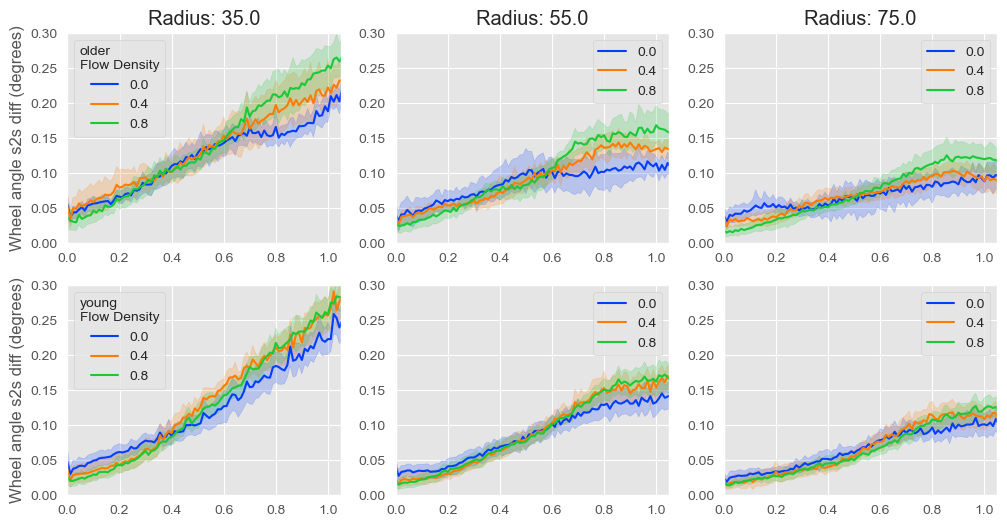

In [10]:
row = 0
col = 0
uneven = ['olderDriver9'] # remove one participant that has uneven num left/right turns
fig, ax = plt.subplots(nrows=2,ncols=3,figsize=(12,6))
for key, section in all_rmse_labeled[~all_rmse_labeled['ppid'].isin(uneven)].groupby(['subject_group','turn_radius']): # group by either subject group or ppid
    
    if row<3:
        row_idx = 0
        ax[row_idx,col].set_title('Radius: ' + str(key[1]))
    else: 
        row_idx = 1
        ax[row_idx,col%3].set_xlabel('Time (sec)')
    
    section = section.T
    section.columns = section.loc['contrast',:] # set columns titles to be contrast
    ax[row_idx,col%3].set_ylim(0,0.3)
    ax[row_idx,col%3].set_xlim(0.0,1.05)
    colors = sns.color_palette("bright")
    color_idx=0
    for contrast_key, contrast in section.groupby(by=section.columns,axis=1):
        data = contrast.iloc[2:-2,:]
        data = pd.concat((pd.DataFrame(np.array(data.T).reshape(-1,1), columns=[contrast_key]), pd.DataFrame(np.tile(interp_timestamps, len(data.columns)),columns=['interp_timestamps'])),axis=1)
        data.loc[:,'s2s_differences'] = pd.Series()
        data.loc[1:,'s2s_differences'] = pd.Series(data.iloc[1:, 0].values - data.iloc[:-1, 0].values) # calculate sample to sample difference
        sns.lineplot(ax=ax[row_idx,col%3], data=data.iloc[1:,:], x='interp_timestamps', y='s2s_differences', 
              errorbar='ci', label=contrast_key, color=colors[color_idx])
        ax[row_idx,col%3].set_xlabel('')
        ax[row_idx,col%3].set_ylabel('')
        color_idx+=1

    ax[row_idx,0].legend(title=key[0] + '\nFlow Density')
    ax[row_idx,0].set_ylabel('Wheel angle s2s diff (degrees)')
    col+=1
    row+=1
    #plt.savefig(r'SteeringWheelAngle-vs-Time-TrialBeginning-FINAL.svg', dpi=300)

# The following code plots the wheel angle by gaze azimuth for the participants with usable gaze data.

In [11]:
# calculating avg wheel angle across middle 40% per participant by turn radius

wheel_angle_diff = pd.DataFrame()
interp_time_seconds = 7.3 # fix interpolation time for all participants
interp_res_seconds = 1/90
interp_timestamps = np.arange(0, interp_time_seconds, interp_res_seconds) # need to interpolate across time for wheelAngle
wheelAnglesAllTrials = pd.DataFrame()
gazeAzimuthAllTrialsMiddle40 = []

for subnum, subfolder in enumerate(subfolder_list):  
    # remove the ones that don't have gaze data
    if os.path.split(subfolder)[-1] not in ['olderDriver4','olderDriver6','olderDriver8','olderDriver9','youngerDriver9','youngerDriver11','youngerDriver15']:
        print(f'** {subnum+1} / {len(subfolder_list)} :  {os.path.split(subfolder)[-1]}  **')
            
        a_subject = subject_data(subfolder, 
                                 cbPatient=True, 
                                 analyze_gaze=False,
                                 offset_car_xz=(-.4304, 0), 
                                 use_cached_data=True)
        
        df_wheelAngle = pd.DataFrame()
        for row_idx, trial in a_subject.results.iterrows():
            trial = a_subject.get_trial_from_results(trial)
            
            wheelAngleInterp = np.interp(interp_timestamps, trial.car_data['time_in_trial'], trial.car_data['wheelAngle']).reshape(-1)
            wheelAngleInterp = np.concatenate((wheelAngleInterp,[trial.results['turn_radius']],[trial.results['contrast']]),axis=0)
            if trial.results['turn_direction']=='left':
                wheelAngleInterp = -wheelAngleInterp
                # make sure that turn radius and wheel angle are still positive after the negation
                wheelAngleInterp[-1] = np.abs(wheelAngleInterp[-1])
                wheelAngleInterp[-2] = np.abs(wheelAngleInterp[-2])
            
            gazeAzimuthAllTrialsMiddle40.append(np.abs(trial.results['gaze_az_rel_car_filtered_30_70']))
            gazeAzimuthAllTrialsMiddle40.append(os.path.split(subfolder)[-1])
                
            df_wheelAngle = pd.concat((df_wheelAngle, pd.Series(wheelAngleInterp)),axis=1)
        wheelAnglesAllTrials = pd.concat((wheelAnglesAllTrials, df_wheelAngle),axis=1)
    
        df_wheelAngle = df_wheelAngle.T
        wheelAngle = df_wheelAngle.groupby([df_wheelAngle.columns[-1], df_wheelAngle.columns[-2]]).mean()
        wheelAngle.loc[:,'ppid'] = os.path.split(subfolder)[-1]
        wheelAngle.loc[:,'subject_group'] = os.path.split(subfolder)[-1][:5]
        wheel_angle_diff = pd.concat((wheel_angle_diff, wheelAngle),axis=0)

gazeAzimuthAllTrialsMiddle40 = pd.DataFrame(np.array(gazeAzimuthAllTrialsMiddle40).reshape(-1,2))
gazeAzimuthAllTrialsMiddle40.loc[:,0] = gazeAzimuthAllTrialsMiddle40.loc[:,0].astype('float')

** 2 / 24 :  youngerDriver7  **
self.pickle_path:  pickled-data/youngerDriver7_pickle_dict.pbz2
** 3 / 24 :  olderDriver3  **
self.pickle_path:  pickled-data/olderDriver3_pickle_dict.pbz2
** 4 / 24 :  youngerDriver3  **
self.pickle_path:  pickled-data/youngerDriver3_pickle_dict.pbz2
** 5 / 24 :  olderDriver7  **
self.pickle_path:  pickled-data/olderDriver7_pickle_dict.pbz2
** 6 / 24 :  youngerDriver12  **
self.pickle_path:  pickled-data/youngerDriver12_pickle_dict.pbz2
** 7 / 24 :  youngerDriver8  **
self.pickle_path:  pickled-data/youngerDriver8_pickle_dict.pbz2
** 9 / 24 :  olderDriver2  **
self.pickle_path:  pickled-data/olderDriver2_pickle_dict.pbz2
** 10 / 24 :  youngerDriver6  **
self.pickle_path:  pickled-data/youngerDriver6_pickle_dict.pbz2
** 12 / 24 :  youngerDriver2  **
self.pickle_path:  pickled-data/youngerDriver2_pickle_dict.pbz2
** 14 / 24 :  youngerDriver13  **
self.pickle_path:  pickled-data/youngerDriver13_pickle_dict.pbz2
** 15 / 24 :  olderDriver1  **
self.pickle_pa

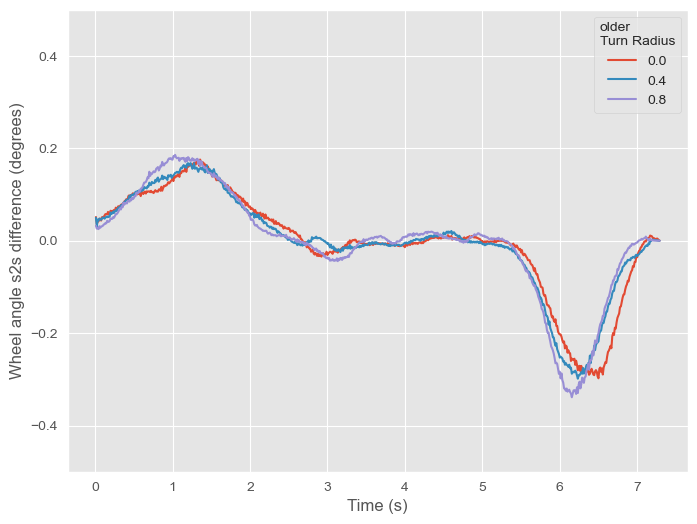

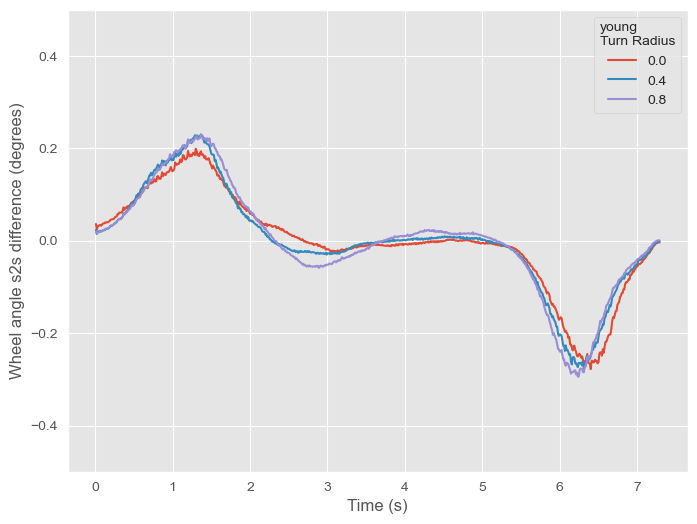

In [12]:
ct=0
for group, section in wheel_angle_diff.groupby('subject_group'): # group by either subject group or ppid
    plt.figure(ct, figsize=(8,6))
    plt.ylim(-0.5,0.5)
    if 'subject_group' in section.columns:
        section = section.iloc[:,:-2].groupby(level=0).mean()
    for row_idx, row in section.iterrows():
        #plt.plot(interp_timestamps, row.values[:-2], label=row.name)
        plt.plot(interp_timestamps[1:], row.values[1:]-row.values[:-1], label=row.name)
        plt.ylabel('Wheel angle s2s difference (degrees)')
        plt.xlabel('Time (s)')
    plt.legend(title=group + '\nTurn Radius')
    ct+=1
    #plt.savefig(r'figs\SteeringWheelRMSE\\' + ppid + '-SteeringRMSE.png', dpi=300)

(5.0, 35.0)

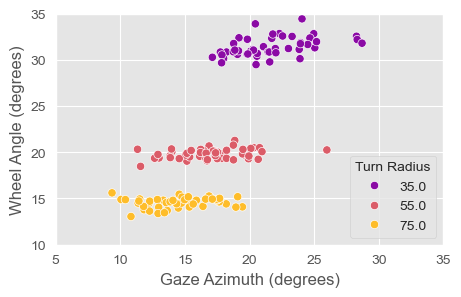

In [13]:
# From this data, you can plot wheel angle vs. gaze azimuth for any participant you want. 

participant = 'youngerDriver1'
middle40 = wheelAnglesAllTrials.iloc[int(0.3*len(wheelAnglesAllTrials)):int(0.7*len(wheelAnglesAllTrials)),:].mean(axis=0)
ppid_data = pd.concat((middle40.reset_index(), pd.DataFrame(gazeAzimuthAllTrialsMiddle40)),axis=1)
ppid_data.drop('index', axis=1,inplace=True)
ppid_data.columns = ['avgWheelAngleMiddle40', 'avgGazeAzimuthMiddle40','ppid']
ppid_data['turn_radius'] = wheelAnglesAllTrials.iloc[-2,:].values
ppid_data['contrast'] = wheelAnglesAllTrials.iloc[-1,:].values

colors = sns.color_palette("plasma")
plt.figure(figsize=(5,3))
sns.scatterplot(ppid_data[ppid_data['ppid']==participant], x='avgGazeAzimuthMiddle40', y='avgWheelAngleMiddle40', hue='turn_radius',palette=[colors[1],colors[3],colors[5]])
plt.legend(title='Turn Radius', loc='lower right')
plt.xlabel('Gaze Azimuth (degrees)')
plt.ylabel('Wheel Angle (degrees)')
plt.ylim(10,35)
plt.xlim(5,35)

## Save data for use with JASP to determine statistical significance

In [14]:
save_data = pd.DataFrame()
exclude= [] # because we are using cb2-redo and cb5-redo so we have their gaze data too
for ppid, ppid_group in all_results.groupby('ppid'):
    if ppid not in exclude:
        row_data = []
        for groupkey, group in ppid_group.groupby(['turn_direction', 'turn_radius', 'contrast']):
            save_data.loc[ppid, str(groupkey)] = group['mean_div_from_inner_road_edge_30_70'].mean()
        #pd.concat((save_data, group.mean(axis=0)), axis=0)
#save_data.to_csv('FINAL-Paper-1-ANOVA-Data.csv')

## Plotting steering bias over time, time based data

In [15]:
def plot_steer_vs_time_across_subjects(all_time_series_df, time_start=0, end_time=7.5, collapse_across_OF=False, flag_group=None, saveFig=False):
    '''
    Specify flag group to be 'young' or 'older' to plot groups separately
    '''

    if flag_group != None:
        all_time_series_df = all_time_series_df.T[all_time_series_df.T.loc[:,'subject_group'] == flag_group].T
    # drop the marker categories ppid and subject group
    all_time_series_df = all_time_series_df.drop(all_time_series_df.index[-2:])

    
    length_columns = len(all_time_series_df.columns)
    mean_time_series_df = all_time_series_df.groupby(by=all_time_series_df.columns, axis=1).apply(lambda g: g.mean(axis=1) if isinstance(g.iloc[0,0], numbers.Number) else g.iloc[:,0])
    n = length_columns // len(mean_time_series_df.columns)

    sem_time_series_df = all_time_series_df.groupby(by=all_time_series_df.columns, axis=1).apply(lambda g: g.std(axis=1) / np.sqrt(n) if isinstance(g.iloc[0,0], numbers.Number) else g.iloc[:,0])
    #print(sem_time_series_df)
    sem_time_series_list = []
    sem_time_series_df['turn_radius'] = mean_time_series_df['turn_radius'] # turn radius is all zeros prior to this but we want to group
    for group_key, slices in sem_time_series_df.groupby(['turn_radius']):
        sem_time_series_list.append(slices)

    radiusList = np.unique(np.array(mean_time_series_df['turn_radius'].values,dtype=np.float64))

    # plots the steering bias over time
    idx = 0
    fontsize=14
    fig, ax = plt.subplots(1, 3, figsize=(14,6))
    if flag_group == None:
        plt.suptitle('Effect of Optic Flow on Steering Bias over Time \nn = ' + str(n), fontsize=fontsize+2)
    else: 
        plt.suptitle('Effect of Optic Flow on Steering Bias over Time \n' + flag_group + ', n = ' + str(n), fontsize=fontsize+2)

    colors = sns.color_palette("bright")

    optic_flow_density = ['Low', 'Medium', 'High']

    for group_key, slices in mean_time_series_df.groupby(['turn_radius']):
        # finding only divergence by optic flow columns
        cols = np.array(slices.columns)
        index_chop_at_ppid = slices.columns.get_loc('turn_radius')
        cols = cols[1:index_chop_at_ppid]
        optic_flow_lvs = []
        for i in range(len(cols)):
            optic_flow_lvs.append(cols[i][-3:])
        if collapse_across_OF:
            lower_err = slices.iloc[:,1:len(optic_flow_lvs)+1].mean(axis=1) - sem_time_series_list[idx].iloc[:,1:len(optic_flow_lvs)+1].mean(axis=1)
            upper_err = slices.iloc[:,1:len(optic_flow_lvs)+1].mean(axis=1) + sem_time_series_list[idx].iloc[:,1:len(optic_flow_lvs)+1].mean(axis=1)
        
            x = slices.iloc[:,1:len(cols)+1].mean(axis=1)
            y = slices['interp_timestamps']
            ax[idx].plot(x, y, linewidth=1.5, color='r') #label=optic_flow_lvs[contrast-1]) # get just density from title
            ax[idx].plot(lower_err, y, color='r', alpha=0.1)
            ax[idx].plot(upper_err, y, color='r', alpha=0.1)
            ax[idx].fill_betweenx(y, lower_err, upper_err, alpha=0.2, color='r')
        else:
            lower_err = slices.iloc[:,1:len(optic_flow_lvs)+1] - sem_time_series_list[idx].iloc[:,1:len(optic_flow_lvs)+1]
            upper_err = slices.iloc[:,1:len(optic_flow_lvs)+1] + sem_time_series_list[idx].iloc[:,1:len(optic_flow_lvs)+1]
        
            for contrast in range(1, len(cols)+1):
                x = slices.iloc[:,contrast]
                y = slices['interp_timestamps']
                ax[idx].plot(x, y, linewidth=1.5, label=optic_flow_density[contrast-1], color=colors[contrast-1]) #label=optic_flow_lvs[contrast-1]) # get just density from title
                ax[idx].plot(lower_err.iloc[:,contrast-1], y, color=colors[contrast-1], alpha=0.1)
                ax[idx].plot(upper_err.iloc[:,contrast-1], y, color=colors[contrast-1], alpha=0.1)
                ax[idx].fill_betweenx(y, lower_err.iloc[:,contrast-1], upper_err.iloc[:,contrast-1], alpha=0.2, color=colors[contrast-1])
        ax[idx].axvline(x=2, ls = '--', color='k') # plots vertical dotted line
        ax[idx].set_ylabel('Time (sec)', fontsize=fontsize)
        ax[idx].set_xlabel('Distance to Inner Road Edge (m)', fontsize=fontsize)
        ax[idx].set_xlim(-0.2, 4.2)
        ax[idx].set_ylim(time_start, end_time)
        ax[idx].vlines(x=0,ymin=np.min(y), ymax=np.max(y), color='k')
        ax[idx].vlines(x=4,ymin=np.min(y), ymax=np.max(y), color='k')
        ax[idx].set_title('Radius: ' + str(radiusList[idx]) + 'm', fontsize=fontsize)
        if idx == 1 and not collapse_across_OF:
            ax[idx].legend(title='Flow Density',fontsize='large', title_fontsize='large', loc='lower right')
        idx = idx + 1

    plt.tight_layout()
    
    if saveFig:
        plt.savefig('Paper1-Steering-Bias-Over-Time.png', dpi=300)
    plt.show()

### Prepare data for use in time series plotting function

In [16]:
mean_time_series_df = pd.DataFrame()
for subnum, subfolder in enumerate(subfolder_list):  
    print(f'** {subnum+1} / {len(subfolder_list)} :  {os.path.split(subfolder)[-1]}  **')

    a_subject = subject_data(subfolder, 
                             cbPatient=False, 
                             analyze_gaze=False,
                             offset_car_xz=(-.4304, 0), 
                             use_cached_data=True)
    a_subject.plot_time_vs_steer_bias_all_trials()
    time_series_df = a_subject.time_series_results.groupby(by=a_subject.time_series_results.columns, axis=1).apply(lambda g: g.mean(axis=1) if isinstance(g.iloc[0,0], numbers.Number) else g.iloc[:,0])
    
    ppid = [os.path.split(subfolder)[-1]] * len(time_series_df.columns)
    
    subject_group = [subfolder.split('/')[-1][:5]] * len(time_series_df.columns)
        
    time_series_df.loc['subject_group'] = subject_group
    time_series_df.loc['ppid'] = ppid
    
    mean_time_series_df = pd.concat((mean_time_series_df, time_series_df),axis=1)

** 1 / 24 :  olderDriver8  **
self.pickle_path:  pickled-data/olderDriver8_pickle_dict.pbz2
Plotting time vs. steering bias for olderDriver8
** 2 / 24 :  youngerDriver7  **
self.pickle_path:  pickled-data/youngerDriver7_pickle_dict.pbz2
Plotting time vs. steering bias for youngerDriver7
** 3 / 24 :  olderDriver3  **
self.pickle_path:  pickled-data/olderDriver3_pickle_dict.pbz2
Plotting time vs. steering bias for olderDriver3
** 4 / 24 :  youngerDriver3  **
self.pickle_path:  pickled-data/youngerDriver3_pickle_dict.pbz2
Plotting time vs. steering bias for youngerDriver3
** 5 / 24 :  olderDriver7  **
self.pickle_path:  pickled-data/olderDriver7_pickle_dict.pbz2
Plotting time vs. steering bias for olderDriver7
** 6 / 24 :  youngerDriver12  **
self.pickle_path:  pickled-data/youngerDriver12_pickle_dict.pbz2
Plotting time vs. steering bias for youngerDriver12
** 7 / 24 :  youngerDriver8  **
self.pickle_path:  pickled-data/youngerDriver8_pickle_dict.pbz2
Plotting time vs. steering bias for y

### Use function to plot steering data over time by group

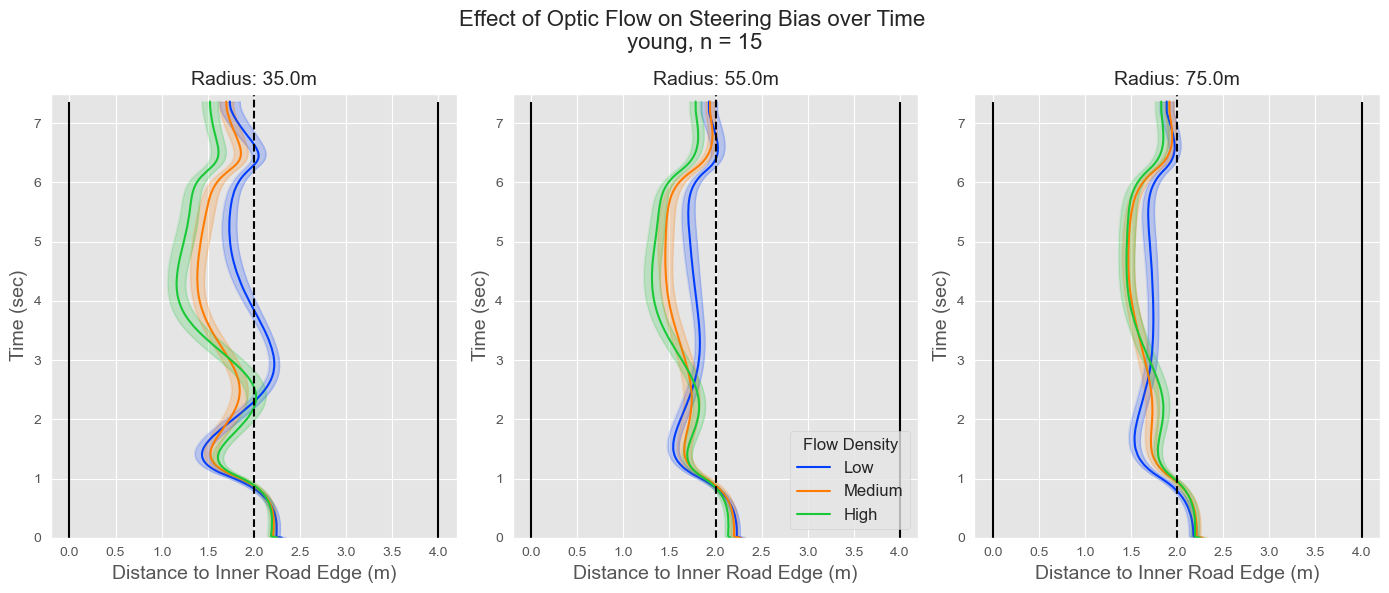

In [17]:
# plot by group by specifying flag here
plot_steer_vs_time_across_subjects(mean_time_series_df, collapse_across_OF = False, flag_group='young', saveFig=False)